In [3]:
import pandas as pd
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import re

In [17]:
def extract_avg_seq_len(input_list):
    
    result_sequences = []
    current_sequence = []

    for number in input_list:
        if not current_sequence or number == current_sequence[-1] + 1:
            current_sequence.append(number)
        else:
            result_sequences.append(len(current_sequence))
            current_sequence = [number]

    if current_sequence:
        result_sequences.append(len(current_sequence))

    # Calculate the average length of sequences
    average_length = sum(result_sequences) / len(result_sequences) if result_sequences else 0
    return average_length

# Missing value analysis

In [60]:
folder_path = '/home/kospsych/Desktop/projects/glucose/data/train'

flag = True
print('Observation 1')
print()
n_files = 0  
cbg_sum = 0
gsr_sum = 0
# Walk through the folder
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        df = pd.read_csv(file_path, sep=',')
        n_files += 1
        cbg_sum += extract_avg_seq_len(df['cbg'].index[df['cbg'].isna()])
        gsr_sum += extract_avg_seq_len(df['gsr'].index[df['gsr'].isna()])

        n_samples = df.shape[0]
        
        if flag:
            whole_df = df
            sum_of_nans = (df.isna().sum() / n_samples * 100)
            flag = False
            if sum_of_nans['hr'] == 100:
                print('patient ',re.search(r'\b\d+\b', file_path).group(), 'has no hr captured')
        else:
            whole_df = pd.concat([df, whole_df], axis = 0)
            current = (df.isna().sum() / n_samples * 100)
            if current['hr'] == 100:
                print('patient ',re.search(r'\b\d+\b', file_path).group(), 'has no hr captured')
            sum_of_nans = (sum_of_nans + current)/2
           
print()
print('------------------------------------')        
print('Observation 2')
print()
print('Average missing values for each feature of the train dataset (%)')
print()
print(sum_of_nans)
print()
print('------------------------------------')        
print('Observation 3')
print()
print('Average size of NaN sequence for cbg feature: ', int(cbg_sum/n_files))
print('Average size of NaN sequence for gsr feature: ', int(gsr_sum/n_files))
print()




Observation 1

patient  584 has no hr captured
patient  540 has no hr captured
patient  544 has no hr captured
patient  567 has no hr captured
patient  552 has no hr captured
patient  596 has no hr captured

------------------------------------
Observation 2

Average missing values for each feature of the train dataset (%)

5minute_intervals_timestamp     0.000000
missing_cbg                     0.000000
cbg                            11.142226
finger                         98.127820
basal                           1.046367
hr                             22.985410
gsr                            13.822740
carbInput                      98.385335
bolus                          98.575281
dtype: float64

------------------------------------
Observation 3

Average size of NaN sequence for cbg feature:  49
Average size of NaN sequence for gsr feature:  53



* **Observation 1:** We observe that some patients have no HR captured, which, according to the text in the paper, "This data is only available for people who wore the Basis Peak sensor band," makes sense. Consequently, the HR feature is dropped because imputation occurs for each patient separately, and creating a feature from scratch based on other features for specific patients is deemed impractical since the setup is based on federated learning and a model trained to impute HR on specific clients may not be available to other clients.
* **Observation 3:** We see that the cbg, gsr features which are measured by instruments tend to have large sequences of continuoysly missing values and thus conclude that the imputation should be done using other features and not with a temporal approach.

# Outlier detection

In [51]:
whole_df.drop(columns = ['5minute_intervals_timestamp', 'missing_cbg', 'hr'], inplace = True)
whole_df.describe()

,cbg,finger,basal,gsr,carbInput,bolus
count,134788.000000,3787.000000,151749.000000,117882.000000,1774.000000,2946.000000
mean,158.948853,157.611566,1.000059,0.859090,44.740699,5.989664
std,60.717516,75.508538,0.417486,3.392687,33.328517,4.382126
min,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113.000000,106.000000,0.730000,0.000089,20.000000,2.700000
50%,151.000000,151.000000,0.980000,0.010315,38.000000,5.000000
75%,197.000000,203.000000,1.250000,0.201129,60.000000,8.500000
max,400.000000,586.000000,2.340000,75.074359,450.000000,25.000000


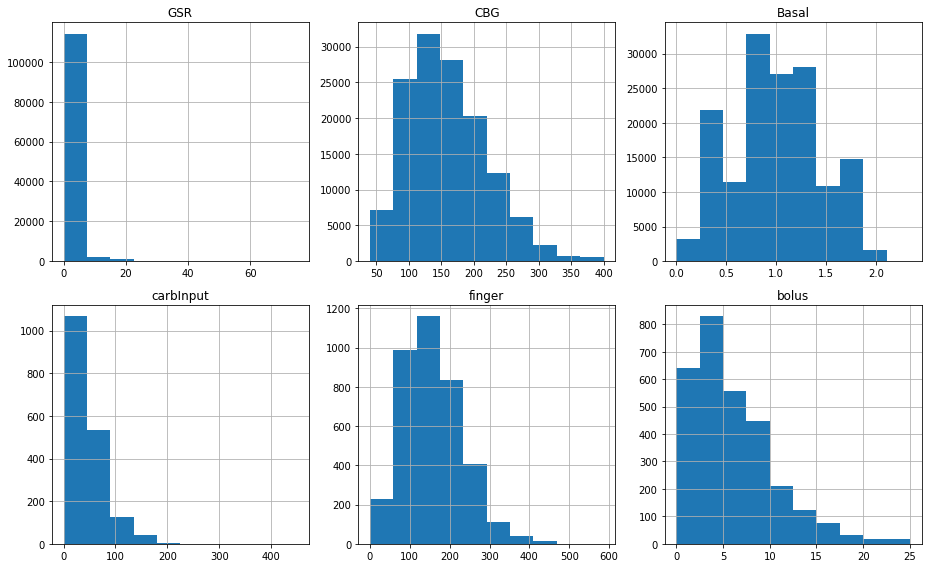

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))

# Plot histograms of each feature
whole_df['gsr'].hist(ax=axes[0, 0])
axes[0, 0].set_title('GSR')

whole_df['cbg'].hist(ax=axes[0, 1])
axes[0, 1].set_title('CBG')

whole_df['basal'].hist(ax=axes[0, 2])
axes[0, 2].set_title('Basal')

whole_df['carbInput'].hist(ax=axes[1, 0])
axes[1, 0].set_title('carbInput')

whole_df['finger'].hist(ax=axes[1, 1])
axes[1, 1].set_title('finger')

whole_df['bolus'].hist(ax=axes[1, 2])
axes[1, 2].set_title('bolus')

# Add labels and show the plot
plt.tight_layout()
plt.show()

Based on the above we see that ___GSR___ and ___carbInput___ have strong positive outliers and a mitigation technique should be applied.